# Metaheuristic algorithms - Lab 3

## Objectives
* Implementation of Evolutionary Algorithms:
 * Combinatorial Optimization (Genetic Algorithms)
 * Continuous optimization (Evolution strategies)
 
## Main steps in designing a genetic algorithm
 
 Let us consider the case when the elements of the population are binary strings. Problems for which such an encoding is appropriate are optimization problems involving Boolean functions (e.g. ONEMAX,  satisfiability problems) or selection problems (e.g. knapsack problem). 

In order to implement a GA there are several components (implemented as separate modules or functions) which should be designed:

* *Population initialization:* usually the population elements are randomly selected from the search space (in the case of binary encoding the search space is $\{0,1\}^n$ ).
* *Population evaluation:* computes the fitness of each element in the population; the way the fitness is computed depends highly on the problem to be solved. Particular attention should be given to constrained optimization problems (in such a case, the constraints can be included in the objective function, e.g. bu using the penalty method).
* *Selection of parents/survivors:* use a stochastic selection procedure;  the typical variants are:
 *	*Proportional selection:* the selection probability is proportional with the fitness value; the indices of the selected elements are generated using the method of inverting the probability distribution function (e.g. roulette or stochastic universal sampler)
 *	*Rank based selection:* the selection probability is proportional with the rank of the element in the increasingly sorted by fitness (for a maximization problem) or decreasingly sorted (for a minimization problem) population;
 *	*Tournament selection:*  several elements are randomly chosen (with or without replacement) from the population and the best one of them is selected; in practice, samples of small size are used (in most cases the sample consists of 2 elements);
 *	*Uniform selection:* the elements are randomly selected, independent of their fitness values (it can be used only for the selection of parents).
*	*Crossover:* starting from two parents constructs two offspring (children):
 * *One cut-point:* for parents $x=(x_1,x_2, \ldots, x_n)$ and $y=(y_1,y_2, \ldots, y_n)$ and a cut point $k$, the children will be $c_1=(x_1,x_2,\ldots ,x_k,y_{k+1},\ldots, y_n)$ and $c_2=(y_1,y_2,\ldots,y_k,x_{k+1},\ldots, x_n)$
 * *Two cut-points:* for parents $x=(x_1,x_2,\ldots, x_n)$ and $y=(y_1,y_2,\ldots, y_n)$ and the cut points $k_1$ and $k_2$, the children will be $c_1=(x_1,x_2,\ldots,x_{k1},y_{k1+1},\ldots, y_{k2}, x_{k1+1},\ldots,x_n)$ and $c_2=(y_1,y_2,\ldots,y_{k1},x_{k1+1},\ldots, x_{k2}, y_{k1+1},\ldots ,y_n)$.
 * *Uniform:* the components of the offspring are taken randomly from the parents, i.e. the parent which provides the value of each component of the first child is selected randomly (usually with probability 0.5); the value of the component in the second child will be taken from the other parent.
*	*Mutation:*
 * *Chromosome-based:*  for each chromosome it is decided (based on the mutation probability) if it should be mutated or not; if the chromosome should be mutated choose a random component and mutate it (by complementing its value).
 * *Gene pool-based:* scan all genes (all components of all elements in the population) and decide based on the mutation probability which genes should be mutated.



## Application 1.  ONEMAX problem
Find the binary string $(x_1, x_2, \ldots, x_n)$ which maximizes $x_1+x_2+\ldots+x_n$.

In [11]:
# Onemax:  problem description and problem-dependent operators
import numpy as np

class Onemax:
    """
    Onemax problem: find the binary string which contains the largest number of ones
    """
    def __init__(self, n):
        """
        Constructor
        :param N - problem size
        """
        self.N = n
    def generate_random_elem(self):
        """
        Generate a vector of N binary elements, having the values in set {0,1}
        """
        return np.random.choice([0, 1], size=(self.N,))
    def eval(self, element):
        """
        Evaluation: compute the sum of all components in the element
        :param element - a population element
        """
        return np.sum(element)
    
    def crossover_one_cut_point(self, el1, el2):
        """
        One-cut-point crossover:
        :param el1:  first parent
        :param el2:  second parent
        :return: two new elements (children)
        """
        cutIndex = np.random.randint(0, self.N) # randomly selected cut point
        child1 = [el1[i] for i in range(cutIndex)]   # child1:  first part from the first parent
        child1.extend([el2[i] for i in range(cutIndex, self.N)]) # child1:  second part from the second parent
        child2 = [el2[i] for i in range(cutIndex)]   # child2:  first part from the second parent
        child2.extend([el1[i] for i in range(cutIndex, self.N)]) # child2:  second part from the first parent
        return child1, child2
    
    def binary_mutation(self, el):
        """
        Element-based binary mutation: one randomly selected component is complemented (0->1, 1->0)
        """
        i = np.random.randint(0, self.N) # random selection of the component to be mutated
        new_el = el.copy()               # copy of the input parameter 
        new_el[i] = 1 - el[i]              # mutation
        return new_el

In [47]:
# Building blocks for a Genetic Algorithm
class Element:
    """
    Population element: encoding (array with binary elementes) + fitness value (scalar)
    """
    def __init__(self, encoding, fitness=0):
        self.encoding = encoding
        self.fitness = fitness
    def __repr__(self):
        return "[el={}, fitness={}]".format(self.encoding, self.fitness)
    
    def copy(self):
        return Element(self.encoding.copy(), self.fitness)
        
def populationInitialization(problem, popSize):
    """
    Initialization of the population by using the random generation method specific to the problem
    """
    population = [Element(problem.generate_random_elem()) for i in range(popSize)]
    return population

def populationEvaluation(problem, population):
    """
    Evaluate each element in the population by using the fitness computation specific to the problem
    """
    for el in population: 
        el.fitness = problem.eval(el.encoding)

def SelectionProbabilitiesComputation(population):
    """
    Computation of the selection probabilities (based on the fitness values)
    """
    n = len(population)
    # computation of the normalization factor
    ProbabilityValues = []
    s = 0.0
    for el in population:
        s += el.fitness
    for el in population:
        ProbabilityValues.append(el.fitness/s)
        
    return ProbabilityValues

def ProportionalSelection(ProbabilityValues):
    """
    Implementation of inverse probability distribution method
    :param ProbabilityValues = array with selection probabilities
    :return k = index of selected element
    """
    k = 0
    s = ProbabilityValues[0]
    u = np.random.rand()
    while u > s:
        k += 1
        s = s + ProbabilityValues[k]
    return k

def RouletteWheel(ProbabilityValues):
    n = len(ProbabilityValues)
    
    indexes = []
    for i in range(n):
        indexes.append(ProportionalSelection(ProbabilityValues))
        
    return indexes

def TournamentSelection(population, populationSize):
    """
    Tournament selection (for a maximization problem) with a sample of size 2
    """
    
    i1 = np.random.randint(0, populationSize)
    i2 = np.random.randint(0, populationSize)
    #print(populationSize,i1,i2)
    if population[i1].fitness > population[i2].fitness:
        return i1
    else:
        return i2
    
def ApplyCrossover(CrossoverFunction, problem, population, indexP1, indexP2):
    return getattr(problem, CrossoverFunction)(population[indexP1].encoding, population[indexP2].encoding)
  
def new_population_build_byCopyChildren(population, children):
    return children

"""
def new_population_build_byConstraintSatisfaction(population, children, limit):
    for i in range(len(population)):
        pc = population[i].fitness
        cc = children[i].fitness
        if pc <= limit and cc <= limit:
            population[i] = children[i].copy()
        elif pc <= limit and cc > limit:
            population[i] = population[i].copy()
        elif pc > limit and cc <= limit: 
            population[i] = children[i].copy()
        elif pc < cc:
            population[i] = population[i].copy()
        else:
            population[i] = children[i].copy()
        
    return population
"""

def new_population_build_byParentsChildrenCompetition(population, children):
    popSize = len(population)
    newPop =[]
    for i in range(popSize):
        i1 = np.random.randint(0, 2*popSize)
        if i1 < popSize:
            el1 = population[i1]
        else:
            el1 = children[i1-popSize]

        i2 = np.random.randint(0, 2*popSize)
        if i2 < popSize:
            el2 = population[i2]
        else:
            el2 = children[i2-popSize]
            
        if el1.fitness > el2.fitness:
            newPop.append(el1.copy())
        else:
            newPop.append(el2.copy())
    return newPop

def GeneticAlgorithm(problem, CrossoverFunction=None, MutationFunction=None, popSize =30, pm=0.1, maxIter = 500,
                    new_population_build = new_population_build_byParentsChildrenCompetition, limit=None, selectionType='proportional'):
    population = populationInitialization(problem, popSize)
    populationEvaluation(problem, population)
    
    it = 0
    while it < maxIter:
        probabilities = SelectionProbabilitiesComputation(population)
    
        children = []
        
        # population of children (offsprings) constructed by applying crossover
        for i in range(popSize//2):
            if selectionType == 'tournament':
                i1 = TournamentSelection(population, popSize)
                i2 = TournamentSelection(population, popSize)
            else:
                i1 = ProportionalSelection(probabilities)
                i2 = ProportionalSelection(probabilities)
            c1, c2 = ApplyCrossover(CrossoverFunction, problem, population, i1, i2)
            children.extend([Element(c1), Element(c2)])
        
        # apply binary mutation on the children
        for i in range(popSize):
            if (np.random.rand()<pm):
                children[i].encoding = getattr(problem, MutationFunction)(children[i].encoding)
                
        populationEvaluation(problem, children)
        
        population = new_population_build(population, children)
        
        it += 1
        
    best = max(population, key=lambda x: x.fitness) # for a maximization problem
    print("Best", best)
    return best

problem = Onemax(30)
GeneticAlgorithm(problem, CrossoverFunction='crossover_one_cut_point', MutationFunction='binary_mutation')

Best [el=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], fitness=30]


[el=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], fitness=30]

### Exercise
Analyze the influence of 
 * (i) population size
 * (ii) mutation probability
 * (iii) selection type 

on the solution quality and on the number of generations  required to reach the optimal solution 

## Application 2. Knapsack problem

Se consideră un set de obiecte (caracterizate prin greutăți specificate prin $w$ și valori specificate prin $v$) și un rucsac de capacitate $C$. Se caută șirul binar $(x_1, x_2, \ldots, x_n)$ care:
* satisface restricția: $w_1*x_1+w_2*x_2+\ldots+ w_n* x_n<=C$ (suma greutăților obiectelor selectate nu depășește capacitatea rucsacului)
* maximizează funcția: $v_1*x_1+v_2*x_2+\ldots+ v_n* x_n$ (suma valorilor obiectelor selectate estemaximă)

**Indicatie**: se folosește codificare binară (elementul $x_i$ este $1$ dacă obiectul $i$ este selectat și $0$ în caz contrar) și se include restricția în funcția obiectiv prin tehnica penalizării. Aceasta înseamnă că funcția scor (care trebuie mazimizată) este: $f(x_1,x_2,\ldots, x_n)= v_1*x_1+v_2*x_2+\ldots+ v_n* x_n$ dacă  $w_1*x_1+w_2*x_2+\ldots+ w_n* x_n\le C$ (restricția este satisfăcută) $f(x_1,x_2,\ldots, x_n)=lambda *( v_1*x_1+v_2*x_2+\ldots+ v_n* x-n )+(1-lambda)* (C- (w_1*x_1+w_2*x_2+\ldots+ w_n* x_n))$ dacă  $w_1*x_1+w_2*x_2+\ldots + w_n* x_n>C$ (restricția este încălcată)

**Obs.** Parametrul $lambda4 ia valori în (0,1) și controlează importanța celor două componente: maximizarea scorului respectiv satisfacerea restricției (cu cât alfa este mai mic cu atât este considerată mai importantă satisfacerea restricției).

In [30]:
class Knapsack:
    def __init__(self, capacity, objects_values, objects_weights):
        self.capacity = capacity
        self.objects_values = np.array(objects_values)
        self.objects_weights = np.array(objects_weights)
        self.N = len(objects_values)
        
    def eval(self, S, lamdba=0.5):
        weight = np.sum(S * self.objects_weights)
        value = np.sum(S * self.objects_values)
        #print (weight, value, S)
        if weight <= self.capacity: # the selected objects fit into the knapsack
            return  value
        else:
            return  (lamdba*value + (1-lamdba) * (self.capacity - weight))
    
    def generate_random_elem(self):
        """random initialization with binary values """
        return np.random.choice([0, 1], size=(self.N,))
    
    def crossover_one_cut_point(self, el1, el2):
        """
        One-cut-point crossover:
        :param el1:  first parent
        :param el2:  second parent
        :return: two new elements (children)
        """
        cutIndex = np.random.randint(0, self.N) # randomly selected cut point
        child1 = [el1[i] for i in range(cutIndex)]   # child1:  first part from the first parent
        child1.extend([el2[i] for i in range(cutIndex, self.N)]) # child1:  second part from the second parent
        child2 = [el2[i] for i in range(cutIndex)]   # child2:  first part from the second parent
        child2.extend([el1[i] for i in range(cutIndex, self.N)]) # child2:  second part from the first parent
        return child1, child2
    
    def binary_mutation(self, el):
        """
        Element-based binary mutation: one randomly selected component is complemented (0->1, 1->0)
        """
        i = np.random.randint(0, self.N) # random selection of the component to be mutated
        new_el = el.copy()               # copy of the input parameter 
        new_el[i] = 1 - el[i]              # mutation
        return new_el

### Exercises

1. Analyze the influence of parameter $\lambda$ used in the computation of the fitness value to incorporate the constraint
2. Modify the tournament selection such that the constraint is checked separately, i.e. for two population elements $e_1$ and $e_2$:
 * if $e_1$ satisfies the constraints and $e_2$ does not satisfy the constraints, then $e_1$ is better than $e_2$ (same is true in the reversed case)
 * if both elements satisfy the constraints then that having a higher fitness is better
 * if both elements do not satisfy the constraints, the elements which violates less them is better

In [43]:
#objects_values = [92,57,59,68,60,43,67,84,87,72]
#objects_weights = [23,31,29,44,53,38,63,85,89,82]
#problem = Knapsack(165, objects_values, objects_weights)
objects_values = [3,4,1,5,2]
objects_weights = [10,8,3,6,5]
problem = Knapsack(20, objects_values, objects_weights)
sol = GeneticAlgorithm(problem,  CrossoverFunction='crossover_one_cut_point', MutationFunction='binary_mutation',   maxIter = 150)
#print("Selected objects", sol.encoding)
OccupiedCapacity=np.sum(np.array(sol.encoding)*objects_weights)
print("Occupied capacity:", OccupiedCapacity)
TotalValue=np.sum(np.array(sol.encoding)*objects_values)
print("Total value:", TotalValue)

Best [el=[0, 1, 0, 1, 1], fitness=11]
Occupied capacity: 19
Total value: 11


## Application 3. Solving TSP using a genetic algorithms

The particularities of a GA designed to solve TSP are:

*	*Solution encoding.*  The natural encoding variant for TSP is the permutation (any tour over n nodes is a permutation of order n specifying the order in which the nodes should be visited).
*	*Parent selection.* Any selection mechanism can be used. For instance: 
 *	Proportional selection
 *	Tournament selection

*	*Crossover operator.*  A simple crossover variant for permutation-like configurations is obtained by extending the one-cut point crossover: for two parents two offsprings are constructed, as follows: 
 *	Choose a random cut point (k)
 *	Transfer the first k components from the first parent to the first offspring; the other components of the first parent are transferred to the first offspring in the order given by the second parent. 
 *	The second offspring is constructed starting from the second parent in a similar way

**Example:** Let $P1=(E,A,C,D,B,F)$,  $P2=(D,C,F,A,E,B)$ and $k=3$. The children will be $C1=(E,A,C,D,F,B)$ and $C2=(D,C,F,E,A,B)$.
     
* Mutation operator (constructing a new configuration starting from the current one). Several mutations can be used for a permutation-like encoding:
 * 2-opt (the variant used in the Simulated Annealing variant):	$(E,A,C,D,B,F) \to (E,D,C,A,B,F)$
 * Exchange of two randomly selected elements: $(E,A,C,D,B,F) \to (E,A,F,D,B,C)$
 * Transfer of a randomly selected element on a randomly selected position: $(E,A,C,D,B,F) \to (E,C,D,B,A,F)$

**Remark:** For TSP, the mutation operator is considered to be more effective than the crossover. 

*	*Survivors selection.*  From the joined population of parents and offspring the elements which survive for the next generation can be selected by:
 *	tournament:  randomly select two elements from the joined population and select the best one 
 *  from the set of 2 parents and 2 offspring choose the best 2 elements 
 *  choose the best m elements (m is the population size) from the joined population 

*  *Control parameters.*  The main control parameters are:

 * Population size
 * Mutation probability
 * Stopping condition. It could be related to the number of generations, to the value of the best element in the population or to other characteristics of the population (e.g. diversity)



In [56]:
%matplotlib inline
import random, numpy, math, copy, matplotlib.pyplot as plt
import numpy as np
class City:
    """coordinates of locations"""
    def __init__(self, coords):
        self.x = int(coords[0])
        self.y = int(coords[1])
    
    def distance(self, city):
        """
        Euclidean distance between two locations
        """
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"
    
    #def getCoord(self):
    #    return [self.x, self.y]

class TSP:
    def __init__(self, filename = None, cities_no = 10):
        """
        input data for a problem (random coordinates or reading from test data file)
        """
        if filename is None:
            self.N = cities_no
            self.cities = [City(random.sample(range(100), 2)) for i in range(n)];
        else:
            self.N, self.cities = self.___read_TSP_file( filename)
        
    def ___read_TSP_file(self, filename):
        nodelist = []

        # Open input file
        with open(filename, 'r') as infile:

            # Read instance header
            Name = infile.readline().strip().split()[1] # NAME
            FileType = infile.readline().strip().split()[1] # TYPE
            Comment = infile.readline().strip().split()[1] # COMMENT
            Dimension = infile.readline().strip().split(":")[1] # DIMENSION
            EdgeWeightType = infile.readline().strip().split()[1] # EDGE_WEIGHT_TYPE
            infile.readline()

            # Read node list
            N = int(Dimension)
            for i in range(N):
                coords = infile.readline().strip().split()[1:]
                nodelist.append(City(coords))

        return N, nodelist
    
    def eval(self, tour):
        """Tour cost computation"""
        val = 0
        for i in range(self.N-1):
            val += self.cities[tour[i]].distance(self.cities[tour[i+1]])
        val += self.cities[tour[0]].distance(self.cities[tour[self.N-1]])
        return -val  # to be minimized
    
    def displayTour(self, tour):
        """tour plot"""
        
        plt.figure(figsize = (16,8))

        plt.axes()
        plt.plot([self.cities[tour[i % self.N]].x for i in range(self.N+1)], [self.cities[tour[i % self.N]].y for i in range(self.N+1)], 'bo-');
        plt.show()
    
    def generate_random_elem(self):
        """initial tour"""
        return random.sample(range(self.N), self.N);

    def simple_mutation(self, S):
        """ 2-opt perturbation """
        i, j = random.sample(range(self.N),2)
        if i > j: i,j=j,i
        new_S = S.copy()
        for k in range((j-i)//2):
            new_S[i+k],new_S[j-k]=new_S[j-k],new_S[i+k]
        return new_S
    
    def recombination_one_cut_point(self, el1, el2):
        k = random.randint(0, self.N)
        child1 = el1[:k]
        child2 = el2[:k]
        child1.extend([x for x in el2 if x not in el1[:k]])
        child2.extend([x for x in el1 if x not in el2[:k]])
        return child1, child2

prob = TSP("eil101.tsp")
#tour = random.sample(range(prob.N),prob.N);
#prob.displayTour(tour)
#print(prob.eval(tour))
#best = GeneticAlgorithm(prob, CrossoverFunction='recombination_one_cut_point', MutationFunction='simple_mutation', maxIter = 5000)
#prob.displayTour(best.encoding)

Best [el=[17, 88, 95, 93, 5, 12, 86, 96, 94, 58, 36, 91, 97, 90, 99, 84, 92, 98, 4, 83, 82, 59, 7, 44, 16, 15, 60, 85, 37, 43, 13, 41, 56, 42, 14, 40, 21, 73, 74, 22, 55, 71, 72, 20, 3, 38, 66, 24, 54, 53, 23, 28, 2, 76, 75, 67, 79, 11, 25, 39, 1, 57, 52, 100, 26, 27, 49, 0, 68, 30, 69, 29, 8, 50, 32, 80, 78, 77, 33, 34, 64, 70, 65, 19, 31, 89, 62, 10, 63, 48, 35, 45, 46, 18, 61, 9, 87, 47, 81, 6, 51], fitness=-729.9887555425481]


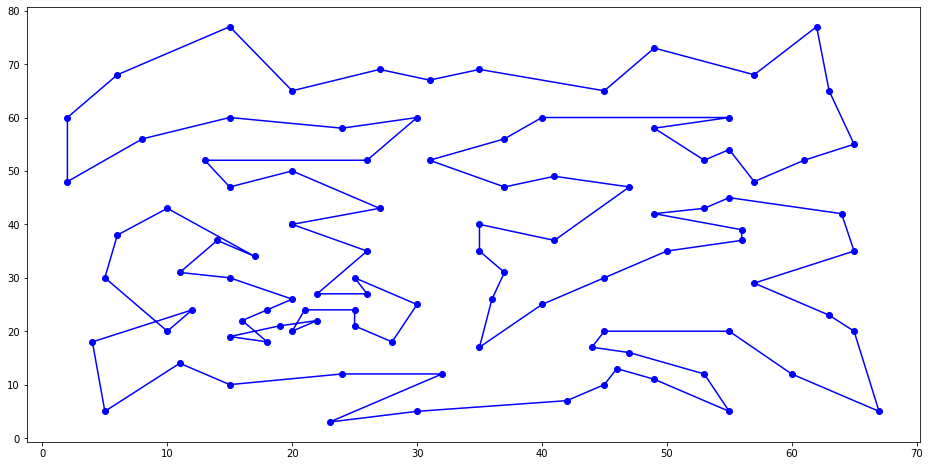

In [55]:
best = GeneticAlgorithm(prob, popSize=100, CrossoverFunction='recombination_one_cut_point', MutationFunction='simple_mutation', maxIter = 5000,
                        selectionType='tournament', new_population_build=new_population_build_byParentsChildrenCompetition)

prob.displayTour(best.encoding)